<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/ClasificadorBinario_efficientnet_b3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=550a08945499aa9ff119547dc4aefbbeec0e5dbf&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f77616c6b776974686661737461692f77616c6b776974686661737461692e6769746875622e696f2f353530613038393435343939616139666631313935343764633461656662626565633065356462662f6e62732f30325f766973696f6e2e65787465726e616c2e74696d6d2e6970796e62&logged_in=false&nwo=walkwithfastai%2Fwalkwithfastai.github.io&path=nbs%2F02_vision.external.timm.ipynb&platform=android&repository_id=295613905&repository_type=Repository&version=98

En este cuaderno probaremos la arquitectura efficientnet_b3 para ver si obtenemos unos mejores resultados.

## Efficientnet_b3

In [ ]:
!pip install fastai -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [6]:
from fastai.vision.all import *

In [15]:
!pip install wwf
!pip install nbdev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.9 MB/s 
     |████████████████████████████████| 561 kB 9.6 MB/s 
     |████████████████████████████████| 53 kB 2.5 MB/s 
     |████████████████████████████████| 133 kB 48.2 MB/s 
     |████████████████████████████████| 106 kB 68.5 MB/s 
     |████████████████████████████████| 132 kB 58.8 MB/s 
     |████████████████████████████████| 428 kB 67.2 MB/s 
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.1.1
    Uninstalling traitlets-5.1.1:
      Successfully uninstalled traitlets-5.1.1
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-c

In [16]:
from wwf.utils import *
from wwf.vision.timm import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [1]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-15 17:35:47 URL:https://uc47354e7cd995efdd3330026b93.dl.dropboxusercontent.com/cd/0/inline2/BnSy42boKzf11miX4Y8xo4gwoI-R7Bu6_V6V-6i2tl_lLJBZfav6xHU884fcryOYzOFjMtOt0AARZNcEyG_iAalmVbkbPVXV78Nsux2bTIOosYHcoZis0zSe-CqYkARApyyMowjEPjJou5haWyp_oe6_33inQtNAOv2kBwZe0zUTADaKnFUANEqO7-NuxGGY-23I3FIh5PEayQpssBfNobZZTi5Qv5QA64iem8CexpSURSLJzyOBhdIR2omA5JvR7E2pYuPgmIz70sjHEeTvBAROXydE1X8U9bMRXdQnew8ZoK8Zo5RipIqxOKbSracpEw2E12mVdquy3_iisu2tgbsFdsWA014c0g2msgATLSHJjiOJAKEI2VZoeLcaLM_NBF-Hds_EoXYxHq5RTPIuUh40JRcFyviy3V98uQMR_qk1lQ/file [138777773/138777773] -> "train.zip" [1]
2022-06-15 17:35:50 URL:https://ucc40b4680fed68a15a7653cf91c.dl.dropboxusercontent.com/cd/0/inline2/BnTBcQeZx94GqMXjVFeb4rdBF5NrilhRilBIX_Ak-7Hn5FxaYimGDPjk7-pRmpCQzUePTutz5oJSwqMxyBv4AfmPJvtrcaKcWjwqsvPN8yHYlRo9FApxhIGnPndMVJzV_J0jWBkbDeREdnmSRieVNsjs4UFnGGkvEpvxSD-2CkDt-tCix2eznDb6Xp45ByJfWsrQw_9qCQZUL3TxCJEPh0D1L-uWcHCKHwI698Qn_BIxmQZP98LQU4siFSu8v8Ts_IKXbRBOJoQLRXH4cMGIzEKqOklZaCWWD8cYHfcM7tpG0brF1-zFe-U0ttcnQdgUdMo

In [2]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [3]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [4]:
crearEstructura('dataset', ['normal', 'enfermedad'])

In [7]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [8]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

#### Mover imágenes:

In [9]:
import shutil

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.move(pathO + '/' + str(id) + '.png', pathD + '/normal')
    else:
        shutil.move(pathO + str(id) + '.png', pathD + '/enfermedad')

In [10]:
path = Path('dataset')

In [11]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

## Cargando el dataset

In [12]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [13]:
dls = db.dataloaders(path,bs=128)

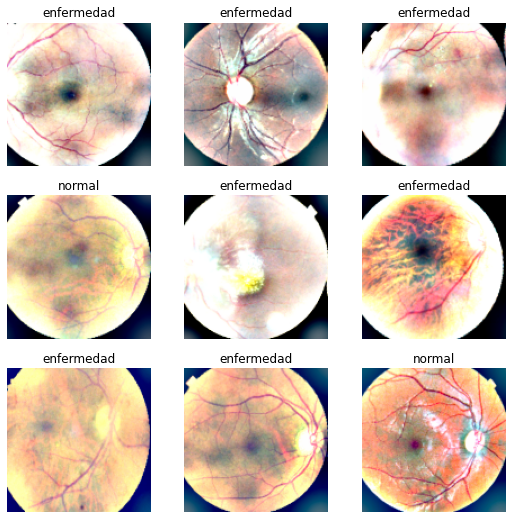

In [14]:
dls.show_batch()

In [17]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback()  
]

In [18]:
learn = timm_learner(dls, 'efficientnet_b3', metrics=[error_rate, accuracy], cbs=callbacks)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


SuggestedLRs(minimum=0.00831763744354248, steep=0.04786301031708717, valley=0.0014454397605732083, slide=0.0063095735386013985)

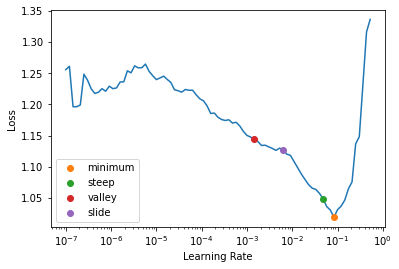

In [19]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.219625,2.229925,0.196875,0.803125,00:12


Better model found at epoch 0 with valid_loss value: 2.2299246788024902.


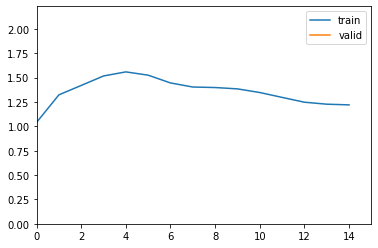

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.006834,0.568442,0.175000,0.825000,00:12
1,0.801964,0.497338,0.223438,0.776563,00:13
2,0.663271,0.423769,0.168750,0.831250,00:12
3,0.575006,0.419960,0.196875,0.803125,00:12
4,0.540701,0.429967,0.157813,0.842188,00:12
5,0.502702,0.350001,0.160938,0.839063,00:12
6,0.460279,0.340954,0.156250,0.843750,00:12
7,0.428175,0.442394,0.181250,0.818750,00:12
8,0.397000,0.368683,0.135937,0.864062,00:12
9,0.378781,0.382881,0.153125,0.846875,00:12


Better model found at epoch 0 with valid_loss value: 0.5684422254562378.


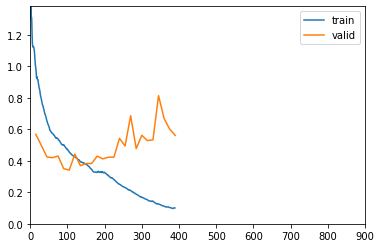

Better model found at epoch 1 with valid_loss value: 0.49733811616897583.
Better model found at epoch 2 with valid_loss value: 0.42376914620399475.
Better model found at epoch 3 with valid_loss value: 0.4199598729610443.
Better model found at epoch 5 with valid_loss value: 0.35000142455101013.
Better model found at epoch 6 with valid_loss value: 0.34095412492752075.
No improvement since epoch 6: early stopping


In [20]:
learn.fine_tune(60,base_lr=1e-1)

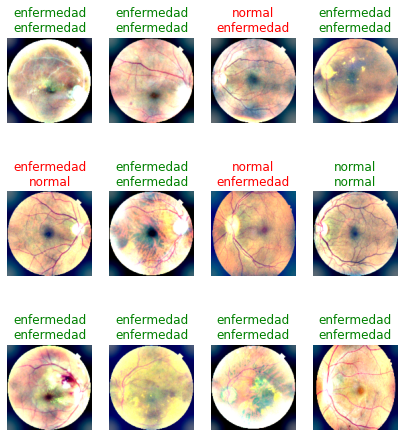

In [23]:
learn.show_results(max_n=12, figsize=(7,8))

## Evaluando el Modelo

In [24]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [25]:
learn.dls = dlsTest

In [26]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.13593749701976776.


(#3) [0.3252195715904236,0.13593749701976776,0.864062488079071]

Exportamos el modelo:

In [27]:
learn.to_fp32()
learn.export('modeloBinario_efficientnet_b3.pkl')